### MLP 로 손글씨 분류하기

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

# 손글씨 숫자 데이터셋인데, 8x8 이미지에서 행렬로 표현된 데이터셋
digits = load_digits() # 8x8 pixel images of handwritten digits

### 기본적인 손글씨 데이터 구조의 이해

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]
0
The number of data: 1797


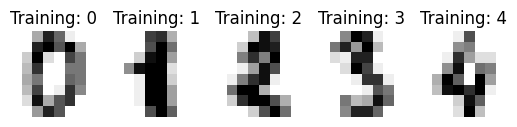

In [7]:
print(digits.images[0])
print(digits.target[0])
print(f'The number of data: {len(digits.images)}')

# zip은 여러개의 iterable을 받아서, element-wise로 묶어 tuple로 이루어진 새로운 iterable을 만든다.
# 이를 list로 변환하면, 각 이미지와 레이블이 tuple로 묶인 리스트가 된다.
# 즉, 첫번째 원소는 (8x8 이미지, 이미지 해당하는 숫자)의 tuple이 된다.
images_and_labels = list(zip(digits.images, digits.target))

# enumerate는 iterable을 받아서, index=0,1,2,3...와 element= (image, label) 로 이루어진 새로운 iterable을 만든다.
# 즉, ( index, element ) 이렇게 묶인 iterable이 된다.
# 이를 이용해서, 처음 5개의 이미지와 레이블을 출력한다.
for index , (image, label) in enumerate(images_and_labels[:5]):

    # 2rows 5columns의 subplot을 만들고, 각 subplot에 번호를 부여한다. 1~5까지
    plt.subplot(2, 5, index + 1)
    plt.axis('off')

    # 이미지 시각화 메소드. 
    # cmap은 colormap으로, 여러가지 색상을 지정할 수 있다.
    # interpolation은 이미지를 나타내는 방식이다. nearest는 smoothing하지 않고, 가장 가까운 픽셀의 색상을 사용한다.
    # image는 여러가지 포맷의 이미지를 받을 수 있다. 대표적으로, grayscale, RGB, RGBA 등이 있다.
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f'Training: {label}')

### MLP 이용해서, 분류기 구성하기

In [9]:
# 훈련데이터 설정

# digits.data는 8x8 이미지를 64개의 픽셀로 펼친 데이터셋이다.
# 이렇게 하면, 8x8행렬 데이터 타입보다 좀 더 수월하게 학습이 가능하다.
X = digits.data
Y = digits.target

# torch.tensor를 이용해서, numpy array를 torch tensor로 변환한다.
X = torch.tensor(X, dtype=torch.float32) # (64,) 1차원 텐서 : 이미지 텐서
Y = torch.tensor(Y, dtype=torch.int64)   # (1,) 1차원 텐서  : 정답레이블

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# nn.Sequential을 이용하여, 다층 레이어 구성하기
# nn.Module을 상속받아서, 나만의 NN을 구성한다.
class HandwrittenDigitClassifier(nn.Module):
    def __init__(self):

        # super()를 이용해서, 부모 클래스의 생성자를 호출한다.
        super(HandwrittenDigitClassifier, self).__init__()


        # nn.Sequential을 이용해서, 각 레이어를 순차적으로 쌓는다.
        self.layer1 = nn.Sequential(
            nn.Linear(64, 32),  #선형 레이어 : 입력값 64개(8x8 이미지), 출력값 32개
            nn.ReLU()           #활성화 함수 : ReLU함수를 통해서 비선형성을 부여한다.
        )

        self.layer2 = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(16, 10),  #최종 출력값은 10개의 클래스로 구성된다. 0~9까지의 숫자
        )
    
        # 결과적으로 출력되는 10개의 값들은 예측값이다.
        # 이후 cross entropy loss에 이 값들과, 실제 정답 레이블을 넣어서 cost를 구성한다.
        # 학습과정에서 이 cost를 최소화하는 방향으로 학습을 진행할 것이다. ( nn.Linear 에 내장된 가중치와 편향을 조절한다. )
        
    # 순전파 메소드를 통해서, 입력값 x를 받아서, 각 레이어를 통과시킨다.
    # 인스턴스를 정의해서 model = HandwrittenDigitClassifier()로 만들고, model(x)로 호출하면, 이 메소드가 실행된다.
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

![NN image 64->32->16->10](../images/nn.svg)

In [10]:
# 모델 인스턴스 생성
model = HandwrittenDigitClassifier()

# 다중 분류문제이므로 cross entropy loss를 사용한다.
# CrossEntropyLoss는 softmax함수와 negative log likelihood loss를 합친 것이다.
cost = nn.CrossEntropyLoss()

# 최적화 알고리즘은 Adam을 사용한다. ( Adaptive Moment Estimation : RMSprop + Momentum )
# Adam은 경사하강법의 일종인데, 이전 에포크의 기울기를 누적해서 관성을 부여하고, 각 파라미터에 대해 학습률을 조절한다.
optimizer = optim.Adam(model.parameters()) # default lr=0.001

losses = [] # cost값을 저장해서, 그래프로 출력할 것이다.

# 학습을 진행한다.

for epoch in range(100):
    
    # 이전 에포크 기울기를 초기화해서, 이번 에포크의 기울기를 구한다.
    optimizer.zero_grad()

    # 모델에 입력값을 넣어서, 예측값을 구함. ; 10개의 클래스값 반환
    Y_prediction = model(X)

    # cost를 구한다음에, 최적화를 진행한다.
    loss = cost(Y_prediction, Y)
    loss.backward() # 역전파를 통해서, 각 파라미터에 대한 기울기를 구한다.
    optimizer.step() # 최적화 알고리즘(Adam)을 통해서, 파라미터를 업데이트한다.

    # 10에포크마다, cost를 출력한다.
    if epoch % 10 == 0:
        print(f'epoch: {epoch}/100  Cost: {loss.item()}')

    # cost를 저장한다.
    losses.append(loss.item())
    


epoch: 0/100  Cost: 2.4689035415649414
epoch: 10/100  Cost: 2.0035781860351562
epoch: 20/100  Cost: 1.7136226892471313
epoch: 30/100  Cost: 1.361694574356079
epoch: 40/100  Cost: 0.9717889428138733
epoch: 50/100  Cost: 0.673910915851593
epoch: 60/100  Cost: 0.48292699456214905
epoch: 70/100  Cost: 0.3599174916744232
epoch: 80/100  Cost: 0.2776836156845093
epoch: 90/100  Cost: 0.2224757820367813


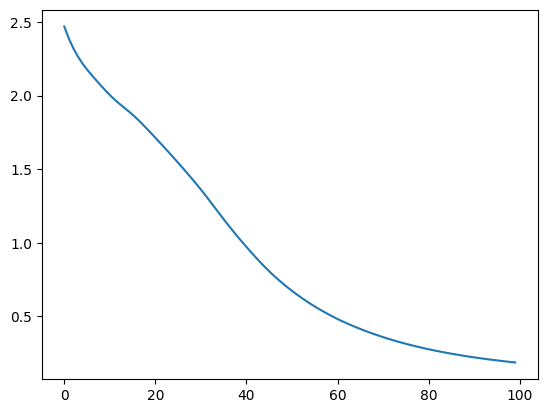

In [11]:
# cost 그래프 출력
plt.plot(losses)

### 손글씨 분류 학습이후, 테스트 및 정확도 계산

In [17]:
# 모델을 평가한다.
with torch.no_grad(): # 테스트시 기울기 반영하지 않음
    # 훈련데이터 X를 모델에 넣어서, 10개의 클래스값을 예측한다.
    # 이 텐서는, 1797개의 이미지 각각에 대해서, 10개의 클래스값을 리스트로 가지고 있다.
    # torch.tensor([[],[],[],...,[10개의 클래스값]]), shape=(1797, 10)
    Y_prediction = model(X)

    # 예측값은 10개의 클래스값이 나오는데, 이 중에서 가장 큰 값의 인덱스를 선택한다.
    # 왜냐면, one-hot encoding으로 만들기 위해서, 가장 큰 하나의 값만 1로 만들고 나머지는 0으로 만들기 위해서이다. 
    # Y_prediction은 shape=(1797, 10)이므로, dim=1 : 열을 따라서 가장 큰 값의 인덱스를 반환한다.
    # 열을 따르다 = 열 방향으로 각 행을 따라서 가장 큰 값의 인덱스를 반환한다.

    # torch.argmax의 반환값은 가장 큰 값의 인덱스 = 예측하는 숫자 를 포함한 1차원 텐서이다.
    # 이를 Y 정답 레이블 1차원 텐서와 element-wise로 비교해서, 같으면 True, 다르면 False를 반환한다.

    correct_prediction = (torch.argmax(Y_prediction, 1) == Y).float()

    # 정확도를 계산한다.
    # sum()을 통해서, True의 개수 합을 구한뒤, item을 통해 스칼라값으로 변환한다.
    # 이를 전체 데이터의 개수로 나눠서, 정확도를 구한다.
    accuracy = correct_prediction.sum().item() / len(correct_prediction)
    
    print(f'Accuracy: {accuracy}')
    

Accuracy: 0.9554813578185866
